# APS 3

___

####  <font style='font-family:Georgia' color='darkturquoise'> Arthur

### Importando bibliotecas e valores

In [106]:
from funcoesTermosol import *
import numpy as np
import math
from time import perf_counter

In [107]:
def matprint(mat, fmt="g"):        # Credits to braingineer https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

### Representação da estrutura

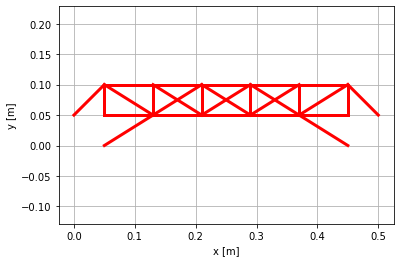

In [108]:
entrada = "entrada2.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [109]:
# Comprimento 
L = 4
#numero de nodes
n = 8

### Gerando a matriz de conectividade transposta

In [110]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
matprint(C_t)

 0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
-1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0  
 1  -1   0   0   0   0   0   0   0   0   0   1  -1   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0  
 0   1  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  -1  -1   0  
 0   0   1  -1   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0   0  -1  
 0   0   0   1  -1   0   0   0   0   0   0   0   0   0   1  -1   0   0  -1   0   0   0   0   1   0   0   0   0  
 0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  
 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0  
 0   0   0   0   0  -1   0   0   0   0   1  -1   0   0   0   0   0   0   0   1   0   0   0   0  

### Matriz dos membros (M)

In [111]:
M = np.matmul(N, C_t)
print(M)

[[ 0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.08  0.05  0.08
   0.08  0.08  0.08  0.08  0.05  0.08  0.08  0.    0.    0.    0.    0.
   0.    0.08 -0.08  0.08]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.05 -0.05
   0.05 -0.05 -0.05  0.05 -0.05  0.05 -0.05  0.05 -0.05 -0.05 -0.05 -0.05
  -0.05  0.05  0.05  0.05]]


### Obtendo Se, Ke e Kg

In [112]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 2828427.12474619  2828427.12474619        0.         ...
         0.                0.                0.        ]
 [ 2828427.12474619  2828427.12474619        0.         ...
         0.                0.                0.        ]
 [       0.                0.          5000000.         ...
         0.                0.                0.        ]
 ...
 [       0.                0.                0.         ...
   1191008.85393973        0.                0.        ]
 [       0.                0.                0.         ...
         0.          3048982.66608571 -1905614.16630357]
 [       0.                0.                0.         ...
         0.         -1905614.16630357  1191008.85393973]]


### Deslocamento nodal

Aplicando as condições de contorno para a matriz das forças:

In [113]:
F_c = np.delete(F, R.astype(int))
F_c


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., -75.,   0., -75.,   0.,   0.,   0.,   0.])

Aplicando as condições de contorno para a matriz da rigidez:

In [114]:
Kg_c = np.delete(Kg, R.astype(int),0)
Kg_c = np.delete(Kg_c, R.astype(int), 1)
matprint(Kg_c)

 5e+06        -5e+06             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0             0  
-5e+06   1.91469e+07   1.90561e+06        -5e+06             0             0             0             0             0             0  -3.04898e+06   1.90561e+06             0             0  -3.04898e+06  -1.90561e+06             0             0             0             0             0             0  
     0   1.90561e+06    1.1573e+07             0             0             0             0             0             0             0   1.90561e+06  -1.19101e+06             0        -8e+06  -1.90561e+06  -1.19101e+06             0             0             0             0             0             0  
     0        -5e+06             0    1.6098e+07             0        -5e+06             0 

___
**Funções de Jacobi e Gauss-Seidel utilizadas na aula 21:**

In [115]:
# def jacobi(k,F,ite,tol):
#     #inicializando X com 
#     x = np.zeros(k.shape[0])

#     # Cria um vetor com os elementos da diagonal de k                       
#     diagonal = np.diag(k)
#     # Subtrai a diagonal de K
#     k_d = k - np.diagflat(diagonal)
#     # loop até chegar abaixo da tolerância ou passar do número máximo de iterações
#     for i in range(ite):
#         x2 = (F - np.matmul(k_d,x)) / diagonal
#         error =  max(abs((x2 - x)/x2) )
#         if error < tol:
#             print(f"Erro máximo: {error}")
#             print(f"Convergiu na iteração: {i}")
#             return x2
        
#         x = x2
#     return x
def jacobi(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

In [116]:
# def gauss_seidel(A, b, ite, tol):
#     x = np.zeros_like(b, dtype=np.double)
    
#     #Iterate
#     for k in range(ite):
        
#         x_old  = x.copy()
        
#         #Loop over rows
#         for i in range(A.shape[0]):
#             x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
#         #Stop condition 
#         if np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) < tol:
#             break
            
#     return x
def gauss_seidel(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U_[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

___
Utilizando Jacobi, Gauss-Seidel e a forma geral para cálculo da matriz **U**

In [117]:
u_jacobi = jacobi(Kg_c, F_c, 1000, 1e-5)
print("Método Jacobi:")
timer_start = perf_counter()
matprint(jacobi(Kg_c, F_c,1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 1000
Método Jacobi:
Iterações: 1000
 2.25177e+19  
-2.39071e+19  
-3.81839e+19  
 2.63475e+19  
-2.78353e+19  
 -2.3967e+19  
-2.39305e+19  
 1.67505e+19  
-3.23831e+19  
 2.39499e+19  
 1.30973e+19  
 9.40837e+17  
-3.00518e+19  
 4.57156e+19  
 2.60726e+19  
 2.69035e+19  
-2.44453e+19  
 2.22158e+19  
 2.94736e+19  
 3.99055e+19  
-1.82767e+19  
 7.15104e+18  
Tempo: 0.38735130200007006


In [118]:
u_gauss = gauss_seidel(Kg_c, F_c, 1000, 1e-5)
print("Método Gauss-Seidel:")
timer_start = perf_counter()
matprint(gauss_seidel(Kg_c, F_c, 1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 221
Método Gauss-Seidel:
Iterações: 221
 -9.0995e-06  
-9.09952e-06  
-4.44701e-05  
-1.18712e-05  
-0.000110106  
-1.39491e-06  
-0.000114503  
-1.31581e-06  
-5.33085e-05  
 -2.7745e-05  
 1.14416e-05  
-3.84232e-06  
 1.27821e-05  
 -4.7864e-05  
 5.43425e-06  
-0.000111719  
-1.55777e-05  
 -0.00011614  
-2.58997e-05  
-5.61576e-05  
-2.89281e-05  
-1.18297e-06  
Tempo: 0.09178442699999323


**Deslocamentos nodais**

In [119]:
U_ar = np.linalg.solve(Kg_c, F_c)
U_ar

array([-9.09983221e-06, -9.09983221e-06, -4.44710833e-05, -1.18716838e-05,
       -1.10108548e-04, -1.39519814e-06, -1.14505448e-04, -1.31602108e-06,
       -5.33100302e-05, -2.77459906e-05,  1.14417440e-05, -3.84238283e-06,
        1.27822483e-05, -4.78650437e-05,  5.43421404e-06, -1.11721337e-04,
       -1.55781529e-05, -1.16142316e-04, -2.59004982e-05, -5.61591883e-05,
       -2.89289986e-05, -1.18300798e-06])

**Ajustando o tamanho das matrizes U**

In [120]:
u_jacobi_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_jacobi_ajustado)):
    if e not in R:
        u_jacobi_ajustado[e] += u_jacobi[i]
        i += 1
u_jacobi_ajustado

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 2.25176556e+19],
       [ 0.00000000e+00],
       [-2.39070949e+19],
       [-3.81839479e+19],
       [ 2.63475122e+19],
       [-2.78353197e+19],
       [-2.39669696e+19],
       [-2.39305187e+19],
       [ 1.67504967e+19],
       [-3.23830736e+19],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 2.39498867e+19],
       [ 0.00000000e+00],
       [ 1.30973210e+19],
       [ 9.40836581e+17],
       [-3.00517968e+19],
       [ 4.57156027e+19],
       [ 2.60726185e+19],
       [ 2.69034907e+19],
       [-2.44453485e+19],
       [ 2.22157947e+19],
       [ 2.94735774e+19],
       [ 3.99054856e+19],
       [-1.82766655e+19],
       [ 7.15103547e+18],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [121]:
u_gauss_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_gauss_ajustado)):
    if e not in R:
        u_gauss_ajustado[e] += u_gauss[i]
        i += 1
u_gauss_ajustado

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-9.09949948e-06],
       [ 0.00000000e+00],
       [-9.09951518e-06],
       [-4.44700753e-05],
       [-1.18712331e-05],
       [-1.10106157e-04],
       [-1.39491060e-06],
       [-1.14502772e-04],
       [-1.31580876e-06],
       [-5.33084845e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-2.77450434e-05],
       [ 0.00000000e+00],
       [ 1.14415916e-05],
       [-3.84232150e-06],
       [ 1.27821256e-05],
       [-4.78639753e-05],
       [ 5.43425351e-06],
       [-1.11719067e-04],
       [-1.55776606e-05],
       [-1.16139759e-04],
       [-2.58997179e-05],
       [-5.61575984e-05],
       [-2.89280601e-05],
       [-1.18297200e-06],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [122]:
u = np.zeros((nn*2,1))
i = 0
for e in range(len(u)):
    if e not in R:
        u[e] += U_ar[i]
        i += 1
u
print("PRECISA SER MENOR QUE ", 20e-3, "m")
print(max(u))
print(abs(min(u)))

PRECISA SER MENOR QUE  0.02 m
[1.27822483e-05]
[0.00011614]


### Reações de apoio

In [123]:
P = np.matmul(Kg,u)
P

array([[-2.14942392e+01],
       [-2.14942392e+01],
       [ 0.00000000e+00],
       [ 3.07390626e+01],
       [ 0.00000000e+00],
       [-3.10862447e-14],
       [ 1.13686838e-13],
       [-1.06581410e-13],
       [-1.42108547e-14],
       [-1.27897692e-13],
       [ 0.00000000e+00],
       [-9.23705556e-14],
       [ 6.58010539e+00],
       [ 9.46406384e+00],
       [ 3.99680289e-15],
       [-1.77635684e-15],
       [-2.84217094e-14],
       [-3.10862447e-14],
       [-2.84217094e-14],
       [-2.84217094e-14],
       [ 0.00000000e+00],
       [-7.50000000e+01],
       [-2.84217094e-14],
       [-7.50000000e+01],
       [-1.27897692e-13],
       [ 1.77635684e-13],
       [ 2.84217094e-14],
       [ 4.26325641e-14],
       [ 1.12489957e+02],
       [ 7.03062231e+01],
       [-9.75758233e+01],
       [ 6.09848895e+01]])

In [124]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[-2.14942392e+01],
       [-2.14942392e+01],
       [ 3.07390626e+01],
       [ 1.12489957e+02],
       [ 7.03062231e+01],
       [ 6.58010539e+00],
       [ 9.46406384e+00],
       [-1.77635684e-15],
       [-9.75758233e+01],
       [ 6.09848895e+01]])

### Deformações, Tenões e Forças internas

In [125]:
deformacoes=[]
tensoes=[]
forcas=[]
massa=0
for i in range (nm):
        
    matriz = [
            u[(int(Inc[i, 0])-1)*2], 
            u[(int(Inc[i, 0])-1)*2 +1], 
            u[(int(Inc[i, 1])-1)*2], 
            u[int(Inc[i, 1]-1)*2 +1]
    ]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))  
    print(f"L{i} = {L}")
    E =  Inc[i, 2]
    #A = 1e-4
    A = Inc[i,3]
    const = E*A/L
    
    massa += L*A*848
    
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]

    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)

print(f"Massa = {massa}")

L0 = 0.08
L1 = 0.07999999999999999
L2 = 0.07999999999999999
L3 = 0.08000000000000002
L4 = 0.08000000000000002
L5 = 0.08
L6 = 0.07999999999999999
L7 = 0.07999999999999999
L8 = 0.08000000000000002
L9 = 0.08000000000000002
L10 = 0.07071067811865477
L11 = 0.09433981132056604
L12 = 0.09433981132056603
L13 = 0.09433981132056603
L14 = 0.09433981132056606
L15 = 0.09433981132056606
L16 = 0.07071067811865475
L17 = 0.09433981132056604
L18 = 0.09433981132056606
L19 = 0.05
L20 = 0.05
L21 = 0.05
L22 = 0.05
L23 = 0.05
L24 = 0.05
L25 = 0.09433981132056603
L26 = 0.09433981132056603
L27 = 0.09433981132056606
Massa = 0.18527269100876384


In [126]:
deformacoes
print("MENOR QUE",4e-4,"(0.008 * 0.05)")
print(max(deformacoes))
print(abs(min(deformacoes)))

MENOR QUE 0.0004 (0.008 * 0.05)
[0.00013096]
[0.00033163]


In [127]:
tensoes
print("MENOR QUE", 18e6, "Pa")
print(max(tensoes))
print(abs(min(tensoes)))

MENOR QUE 18000000.0 Pa
[523824.28049445]
[1326535.165322]


In [128]:
forcas

[array([0.]),
 array([-13.85925772]),
 array([52.38242805]),
 array([0.39588532]),
 array([6.58010539]),
 array([6.70252161]),
 array([-36.7401712]),
 array([-105.0618346]),
 array([-51.61172649]),
 array([-15.14250214]),
 array([30.39744453]),
 array([17.44309803]),
 array([-98.86692153]),
 array([-18.2987611]),
 array([-89.9165726]),
 array([17.85675994]),
 array([0.]),
 array([-132.65351653]),
 array([-115.06605947]),
 array([-30.73906262]),
 array([-27.151683]),
 array([-12.9023124]),
 array([-13.09494123]),
 array([-22.79326522]),
 array([-9.46406384]),
 array([-26.88565868]),
 array([51.22969303]),
 array([43.0062468])]

___
**Gerando Saídas com as 3 matrizes U calculadas anteriormente**

In [129]:
x = geraSaida("geral", P_r, u, deformacoes, forcas, tensoes)

In [130]:
geraSaida("jacobi", P_r, u_jacobi_ajustado, deformacoes, forcas, tensoes)

In [131]:
geraSaida("gauss", P_r, u_gauss_ajustado, deformacoes, forcas, tensoes)